In [123]:
"""ファブリック

点
"""

import numpy as np
from numpy import linalg as LA
from scipy import integrate
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#import robot_sice_ex.sice_ex as sice_ex

def s(x_dot):
    if x_dot < 0:
        return 1
    else:
        return 0

def sigmoid(x, alpha):
    return 1 / (1 + sy.exp(-alpha * x))

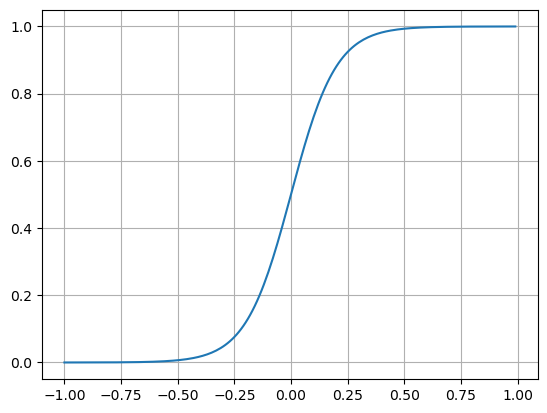

In [138]:
_x = np.arange(-1, 1, 0.01)
_y = [sigmoid(i, 10) for i in _x]
plt.plot(_x, _y)
plt.grid()

In [147]:
# ee attractor
# q = sy.MatrixSymbol('q', 2, 1)
# q_d = sy.MatrixSymbol('q_d', 2, 1)
# phi = q - q_d
# x = phi
# x_norm = sy.sqrt(x[0,0]**2 + x[1,0]**2)

x = sy.MatrixSymbol('x', 2, 1)
x_dot = sy.MatrixSymbol('x_dot', 2, 1)
x_norm = sy.sqrt(x[0,0]**2 + x[1,0]**2)
m_u, m_l, alpha_m, k, alpha_psi = sy.symbols('m_U, m_l, alpha_m, k, alpha_psi')

G = (m_u - m_l) * sy.exp(-(alpha_m * x_norm)**2) * sy.eye(2) + m_u * sy.eye(2)
psi_1 = k * (x_norm + 1/alpha_psi * sy.ln(1 + sy.exp(-2 * alpha_psi * x_norm)))

L = (x_dot.T * G * x_dot)[0,0]
M_ee = sy.Matrix([[
    sy.diff(L, x_dot[0,0]),
    sy.diff(L, x_dot[1,0]),
]]).jacobian(x_dot)

xi_ee = sy.Matrix([
    [sy.diff(L, x_dot[0,0])],
    [sy.diff(L, x_dot[1,0])],
]).jacobian(x) * x_dot \
    - sy.Matrix([
        [sy.diff(L, x[0,0])],
        [sy.diff(L, x[1,0])],
    ])

#M_ee = G
pi_ee = -sy.Matrix([
    [sy.diff(psi_1, x[0,0])],
    [sy.diff(psi_1, x[1,0])],
])

func_M_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), M_ee, "numpy")
func_xi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), xi_ee, "numpy")
func_pi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), pi_ee, "numpy")


In [103]:
xd = np.array([[2, 3]]).T
    
def dX(t, X):
    m_u = 10
    m_l = 1
    alpha_m = 1
    k = 1
    alpha_psi = 1
    

    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    M = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp = 10*x_dot
    f = pi - xi - damp
    a = LA.pinv(M) @ f
    
    # print("M = ", np.ravel(M))
    # print("xi = ", xi.T)
    # print("pi = ", pi.T)
    return np.ravel(np.concatenate([x_dot, a]))

X0 = np.array([0, 0, 0, 0.0])
time_interval = 0.01
time_span = 100
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.grid()
ax.axis('equal')
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
for ax in axes.ravel():
    ax.legend()
    ax.grid()


'The solver successfully reached the end of the integration interval.'

----
障害物

In [115]:
# obs avoidance
r, k_b, alpha_b, alpha_sig = sy.symbols('r, k_b, alpha_b, alpha_sig')
x = sy.Symbol('x')
x_dot = sy.Symbol('x_dot')

G = sigmoid(x_dot, alpha_sig) * k_b / x
L = x_dot * G * x_dot

M = sy.diff(L, (x_dot, 2))
xi = sy.diff(sy.diff(L, x_dot), x) - sy.diff(L, x)
psi_1b = alpha_b / (2 * x**8)
grad_psi_1b = sy.diff(psi_1b, x)


func_M_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), M, "numpy")
func_xi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), xi, "numpy")
func_pi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), grad_psi_1b, "numpy")



q = sy.MatrixSymbol('q', 2, 1)
q_o = sy.MatrixSymbol('q_o', 2, 1)
q_dot = sy.MatrixSymbol('q_dot', 2, 1)
q_ = q - q_o
phi = sy.sqrt(q_[0,0]**2 + q_[1,0]**2) / r - 1
s = phi
J = sy.Matrix([[sy.diff(phi, q[0,0]), sy.diff(phi, q[1,0])]])
#s_dot = 1/r * 1/sy.sqrt(q_[0,0]**2 + q_[1,0]**2) * q_.T * q_dot
s_dot = (J * q_dot)[0,0]

func_s = sy.lambdify((q, q_dot, q_o, r), s, "numpy")
func_s_dot = sy.lambdify((q, q_dot, q_o, r), s_dot, "numpy")
func_J = sy.lambdify((q, q_dot, q_o, r), J, "numpy")


xi =  0.0
pi =  -7.227088508991954e-07
xi =  2.0820533722074547e-06
pi =  -7.227088508991954e-07
xi =  2.2352529834264264e-08
pi =  -7.227088508991954e-07
xi =  3.430658910392085e-08
pi =  -7.227088852430128e-07
xi =  9.536865313605903e-08
pi =  -7.227091140071827e-07
xi =  1.0708637798084216e-07
pi =  -7.227091927493774e-07
xi =  1.2140496804584908e-07
pi =  -7.227092766709101e-07
xi =  1.2086782499289037e-07
pi =  -7.22709252954338e-07
xi =  3.817737022243053e-07
pi =  -7.227109037102834e-07
xi =  6.030142109589737e-07
pi =  -7.22715737928183e-07
xi =  2.3092799603151363e-06
pi =  -7.227664102314962e-07
xi =  2.941625424785494e-06
pi =  -7.227899535296756e-07
xi =  3.4746205341977406e-06
pi =  -7.228080105576157e-07
xi =  3.2367209778756496e-06
pi =  -7.227974960689137e-07
xi =  5.999091019263881e-06
pi =  -7.228972454020231e-07
xi =  9.549065648005501e-06
pi =  -7.230429406133084e-07
xi =  5.656531490942355e-05
pi =  -7.250703837524166e-07
xi =  6.56891637730995e-05
pi =  -7.2547253

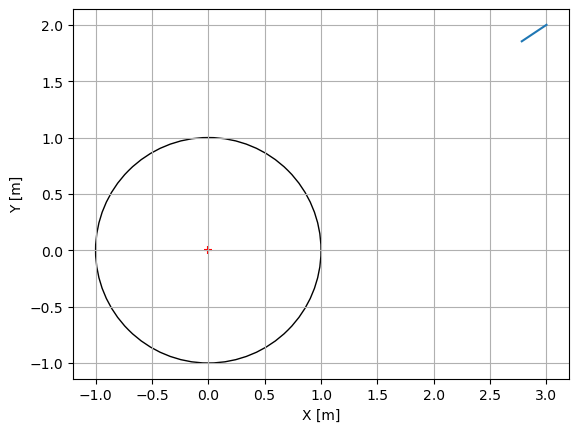

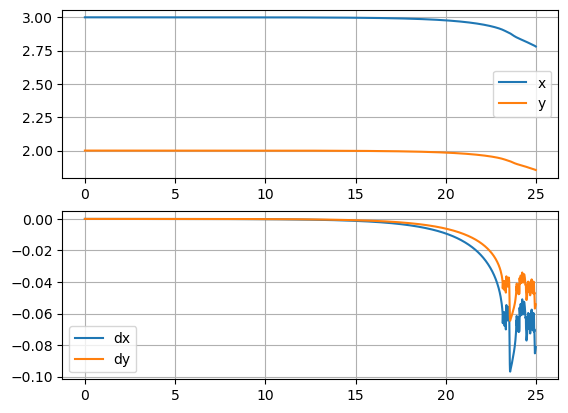

In [161]:
xo = np.array([[0, 0]]).T
r = 1
k_b = 1
alpha_b = 0.001
alpha_sig = 10

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    
    m = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    
    #pi = np.zeros((2,1))
    damp = np.zeros((2,1))
    #damp = 0.01 * s_dot
    
    f = pi - xi - damp
    
    pull_M = m * J.T @ J
    pull_f = J.T * f
    
    a = LA.pinv(pull_M) @ pull_f

    # print("M = ", np.ravel(M))
    print("xi = ", xi.T)
    print("pi = ", pi.T)
    return np.ravel(np.concatenate([x_dot, a]))

X0 = np.array([3, 2, -0., 0.0])
time_interval = 0.01
time_span = 25
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.grid()
ax.axis('equal')
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
for ax in axes.ravel():
    ax.legend()
    ax.grid()


: 